In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chinesecorp/ChnSentiCorp_htl_all.csv


In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import numpy as np
from sklearn.model_selection import train_test_split


In [3]:
# 1. 加载数据
def load_data(file_path):
    # 读取CSV文件，指定编码为utf-8
    df = pd.read_csv(file_path, encoding='utf-8')
    return df

# 2. 创建自定义数据集类

In [4]:
# 2. 创建自定义数据集类
class HotelReviewDataset(Dataset):
    def __init__(self, review, labels, tokenizer, max_length=128):
        self.review = review
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.review)

    def __getitem__(self, idx):
        review = str(self.review[idx])
        label = self.labels[idx]

        # 使用tokenizer处理文本
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 3. 数据处理主函数
def prepare_data(file_path, batch_size=32):
    # 加载预训练的中文BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    
    # 读取数据
    df = load_data(file_path)
    
    # 划分训练集和测试集
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df['review'].values,  # 假设文本列名为'text'
        df['label'].values, # 假设标签列名为'label'
        test_size=0.2,
        random_state=42
    )

    # 创建数据集
    train_dataset = HotelReviewDataset(train_texts, train_labels, tokenizer)
    test_dataset = HotelReviewDataset(test_texts, test_labels, tokenizer)

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

In [5]:
if __name__ == "__main__":
    # 假设数据文件路径
    file_path = "/kaggle/input/chinesecorp/ChnSentiCorp_htl_all.csv"
    
    # 获取数据加载器
    train_loader, test_loader = prepare_data(file_path)
    
    # 打印数据集基本信息
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of testing batches: {len(test_loader)}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Number of training batches: 195
Number of testing batches: 49


In [6]:
import torch
import torch.nn as nn
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
from torch.nn import DataParallel
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [7]:
# 创建保存图表的文件夹
def create_plots_folder():
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    plots_dir = f'training_plots_{current_time}'
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    return plots_dir

# 绘图函数
def plot_training_metrics(train_losses, train_accs, test_accs, plots_dir):
    # 设置风格
    plt.style.use('seaborn')
    
    # 创建图表1：训练损失
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.title('Training Loss Over Time')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{plots_dir}/training_loss.png')
    plt.show()
    plt.close()
    
    # 创建图表2：训练和测试准确率
    plt.figure(figsize=(10, 6))
    plt.plot(train_accs, 'g-', label='Training Accuracy')
    plt.plot(range(len(train_accs))[::len(train_accs)//len(test_accs)], 
             test_accs, 'r-', label='Test Accuracy')
    plt.title('Model Accuracy Over Time')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{plots_dir}/accuracy.png')
    plt.show()
    plt.close()

In [8]:
# 1. 定义模型类
class SentimentClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        return linear_output

# 修改训练函数以记录指标
def train_model(model, train_loader, test_loader, device, num_epochs=5):
    plots_dir = create_plots_folder()
    model = model.to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = DataParallel(model)
    
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    criterion = nn.CrossEntropyLoss()

    # 用于记录指标的列表
    train_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # 记录损失和准确率
            epoch_loss += loss.item()
            train_losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_accs.append(100 * correct / total)

            if batch_idx % 20 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}, '
                      f'Acc: {100 * correct / total:.2f}%')

        # 每个epoch结束后评估
        test_accuracy = evaluate_model(model, test_loader, device)
        test_accs.append(test_accuracy)
        print(f'Epoch {epoch+1} completed. Test Accuracy: {test_accuracy:.2f}%')
        
        # 每个epoch结束后更新图表
        plot_training_metrics(train_losses, train_accs, test_accs, plots_dir)

    # 保存最终的图表
    plot_training_metrics(train_losses, train_accs, test_accs, plots_dir)
    
    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs
    }


In [9]:
# 3. 评估函数
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


Using device: cuda


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Using 2 GPUs!


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1, Batch: 0, Loss: 0.7103, Acc: 37.50%
Epoch: 1, Batch: 20, Loss: 0.2881, Acc: 77.98%
Epoch: 1, Batch: 40, Loss: 0.4718, Acc: 81.86%
Epoch: 1, Batch: 60, Loss: 0.2342, Acc: 83.71%
Epoch: 1, Batch: 80, Loss: 0.3962, Acc: 84.26%
Epoch: 1, Batch: 100, Loss: 0.3796, Acc: 85.12%
Epoch: 1, Batch: 120, Loss: 0.1705, Acc: 85.67%
Epoch: 1, Batch: 140, Loss: 0.4573, Acc: 86.19%
Epoch: 1, Batch: 160, Loss: 0.4667, Acc: 86.67%
Epoch: 1, Batch: 180, Loss: 0.3798, Acc: 86.76%
Epoch 1 completed. Test Accuracy: 88.61%


<ipython-input-7-f659cc5e85ec>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


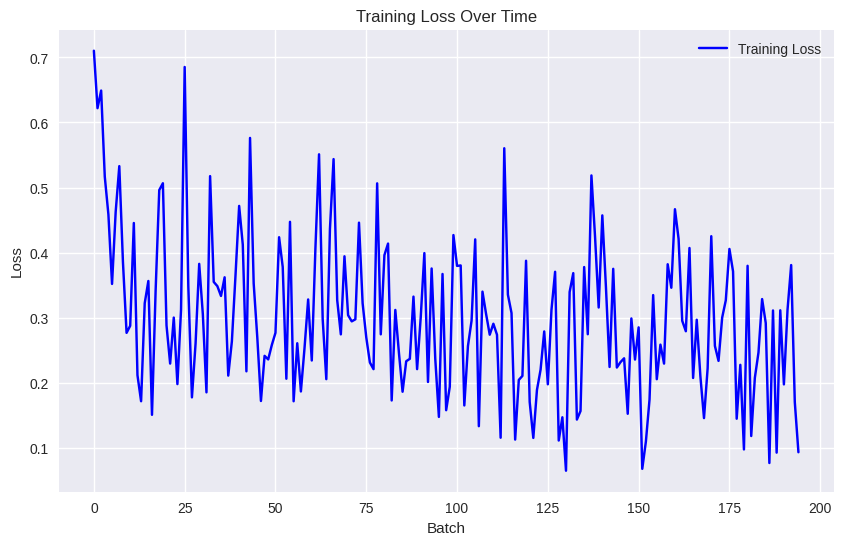

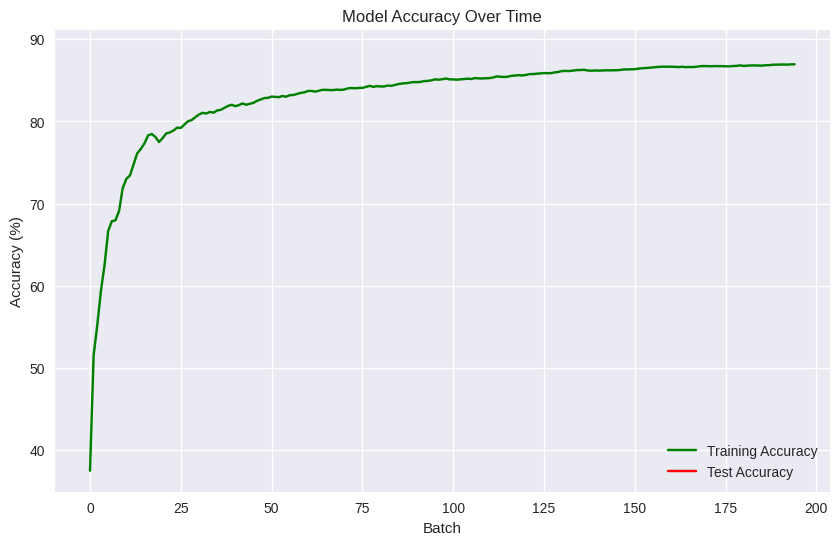

Epoch: 2, Batch: 0, Loss: 0.2638, Acc: 90.62%
Epoch: 2, Batch: 20, Loss: 0.0318, Acc: 92.56%
Epoch: 2, Batch: 40, Loss: 0.1757, Acc: 92.91%
Epoch: 2, Batch: 60, Loss: 0.2111, Acc: 93.14%
Epoch: 2, Batch: 80, Loss: 0.0716, Acc: 93.25%
Epoch: 2, Batch: 100, Loss: 0.2978, Acc: 93.19%
Epoch: 2, Batch: 120, Loss: 0.2717, Acc: 93.57%
Epoch: 2, Batch: 140, Loss: 0.2521, Acc: 93.53%
Epoch: 2, Batch: 160, Loss: 0.2107, Acc: 93.56%
Epoch: 2, Batch: 180, Loss: 0.3989, Acc: 93.70%
Epoch 2 completed. Test Accuracy: 88.74%


<ipython-input-7-f659cc5e85ec>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


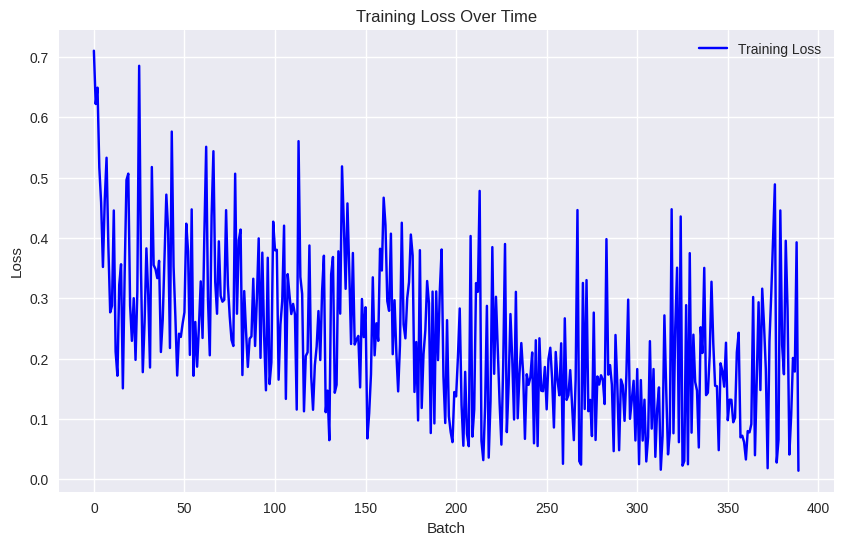

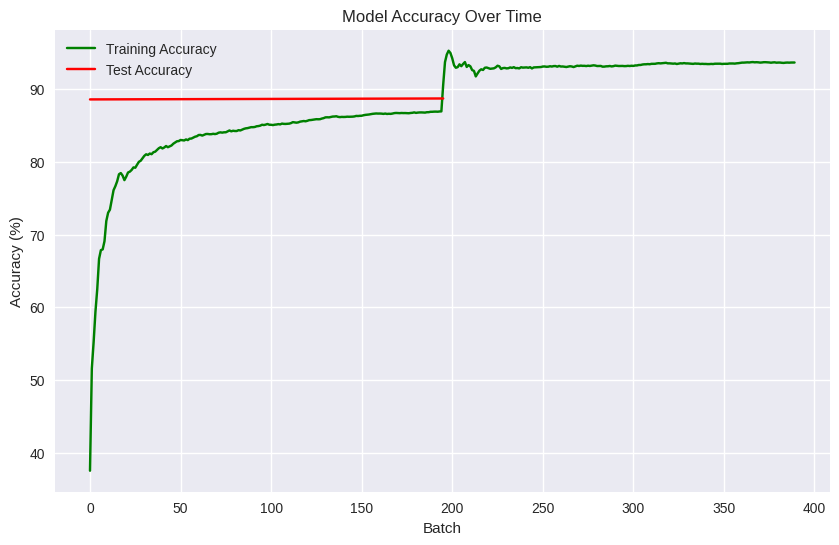

Epoch: 3, Batch: 0, Loss: 0.0329, Acc: 100.00%
Epoch: 3, Batch: 20, Loss: 0.0252, Acc: 98.21%
Epoch: 3, Batch: 40, Loss: 0.2933, Acc: 97.18%
Epoch: 3, Batch: 60, Loss: 0.0697, Acc: 97.08%
Epoch: 3, Batch: 80, Loss: 0.2115, Acc: 97.26%
Epoch: 3, Batch: 100, Loss: 0.0577, Acc: 97.31%
Epoch: 3, Batch: 120, Loss: 0.0183, Acc: 97.42%
Epoch: 3, Batch: 140, Loss: 0.0075, Acc: 97.41%
Epoch: 3, Batch: 160, Loss: 0.0210, Acc: 97.50%
Epoch: 3, Batch: 180, Loss: 0.0962, Acc: 97.39%
Epoch 3 completed. Test Accuracy: 88.93%


<ipython-input-7-f659cc5e85ec>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


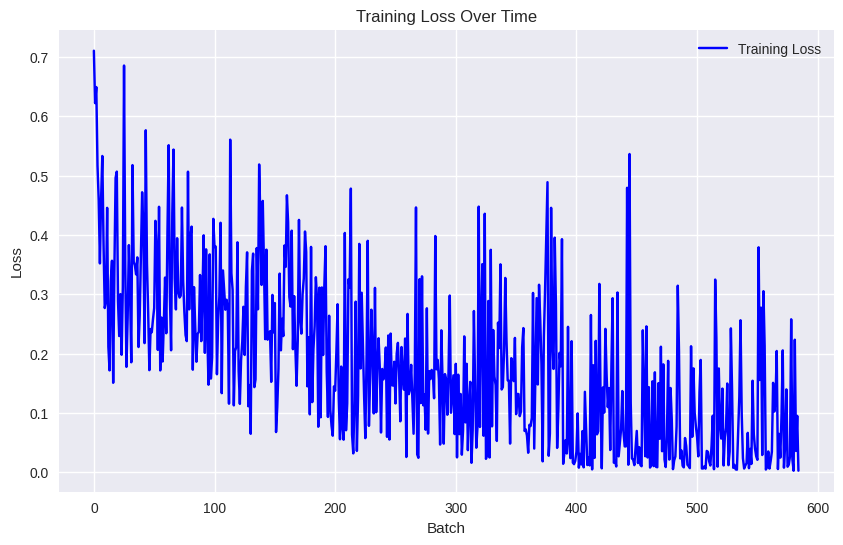

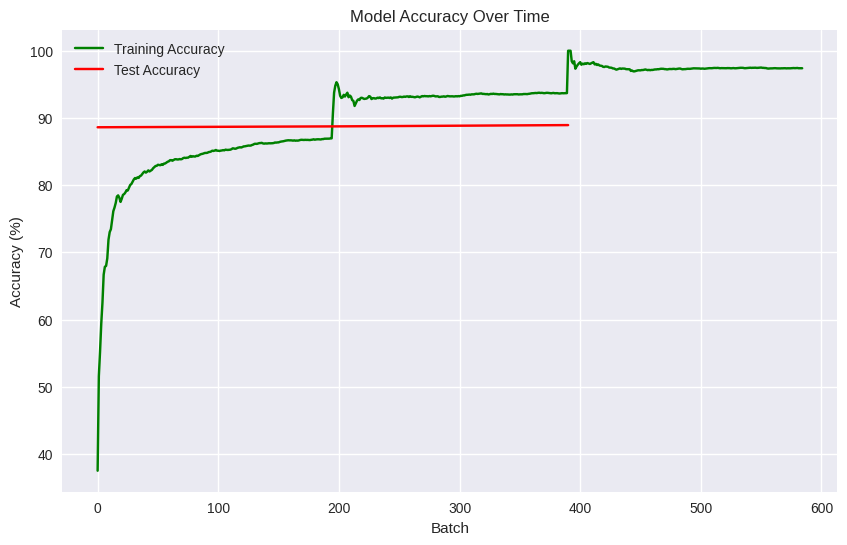

Epoch: 4, Batch: 0, Loss: 0.0055, Acc: 100.00%
Epoch: 4, Batch: 20, Loss: 0.0041, Acc: 99.40%
Epoch: 4, Batch: 40, Loss: 0.0025, Acc: 99.31%
Epoch: 4, Batch: 60, Loss: 0.0771, Acc: 99.23%
Epoch: 4, Batch: 80, Loss: 0.1474, Acc: 99.11%
Epoch: 4, Batch: 100, Loss: 0.0031, Acc: 99.20%
Epoch: 4, Batch: 120, Loss: 0.0024, Acc: 99.04%
Epoch: 4, Batch: 140, Loss: 0.0023, Acc: 99.07%
Epoch: 4, Batch: 160, Loss: 0.0036, Acc: 98.97%
Epoch: 4, Batch: 180, Loss: 0.0824, Acc: 99.00%
Epoch 4 completed. Test Accuracy: 89.32%


<ipython-input-7-f659cc5e85ec>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


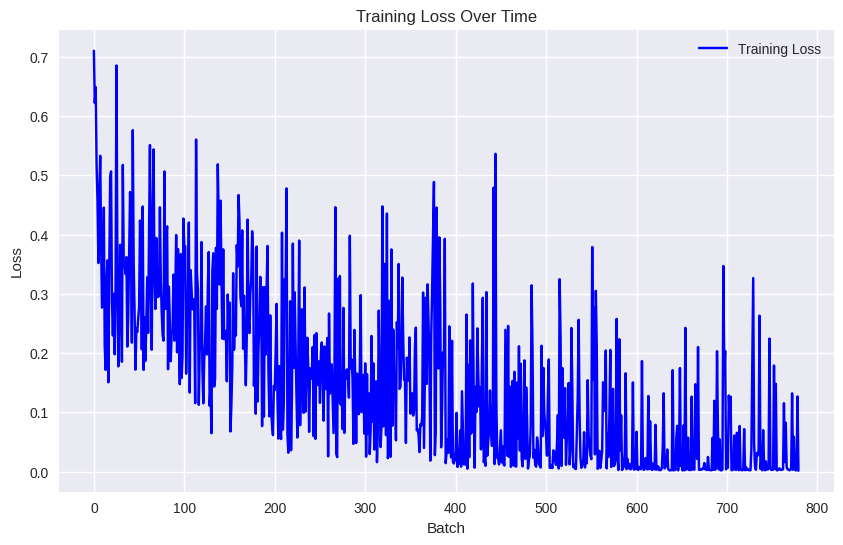

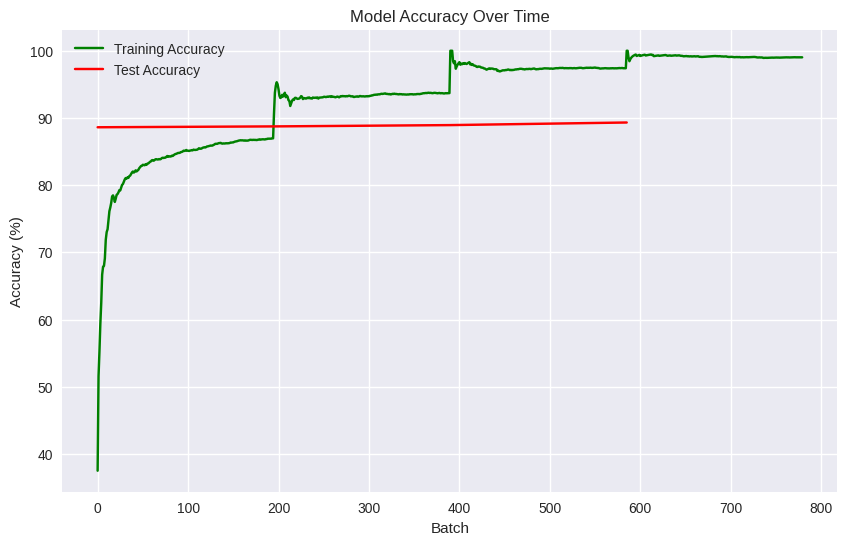

Epoch: 5, Batch: 0, Loss: 0.0021, Acc: 100.00%
Epoch: 5, Batch: 20, Loss: 0.0021, Acc: 99.85%
Epoch: 5, Batch: 40, Loss: 0.0020, Acc: 99.77%
Epoch: 5, Batch: 60, Loss: 0.0013, Acc: 99.74%
Epoch: 5, Batch: 80, Loss: 0.0021, Acc: 99.58%
Epoch: 5, Batch: 100, Loss: 0.0015, Acc: 99.57%
Epoch: 5, Batch: 120, Loss: 0.0062, Acc: 99.54%
Epoch: 5, Batch: 140, Loss: 0.0014, Acc: 99.60%
Epoch: 5, Batch: 160, Loss: 0.0033, Acc: 99.59%
Epoch: 5, Batch: 180, Loss: 0.0013, Acc: 99.55%
Epoch 5 completed. Test Accuracy: 89.19%


<ipython-input-7-f659cc5e85ec>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


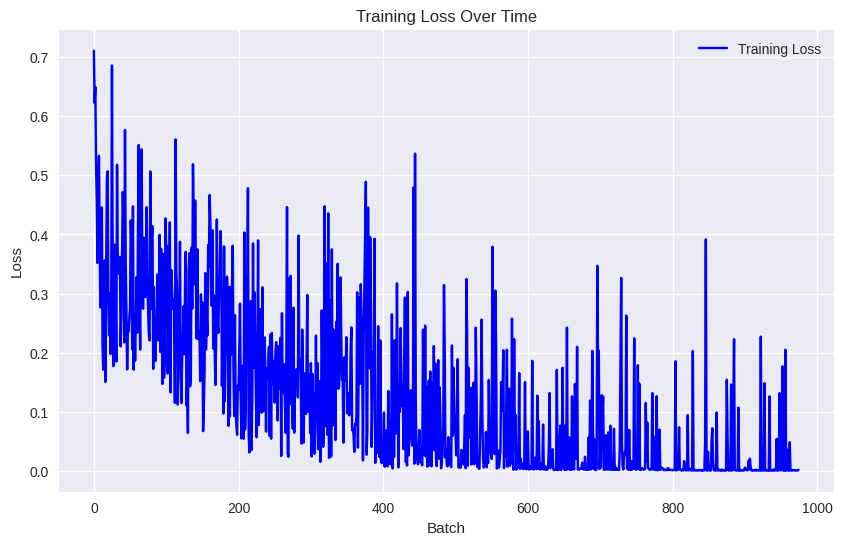

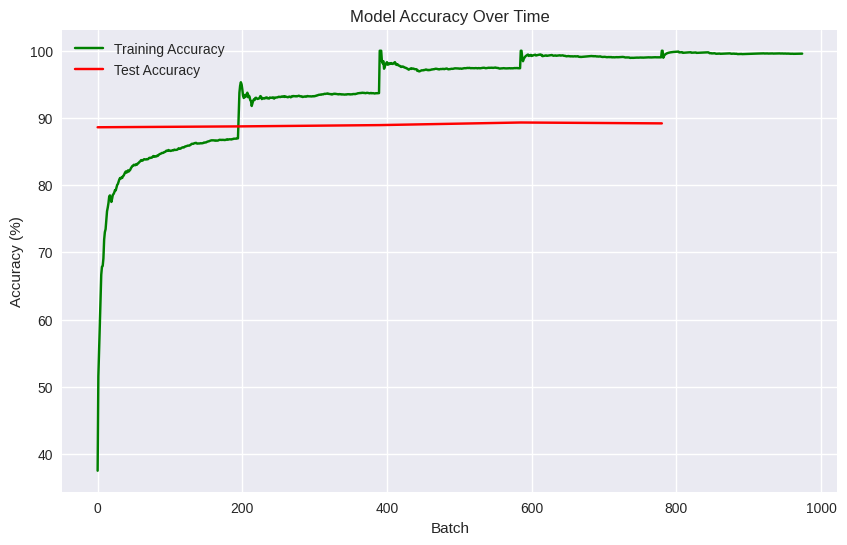

<ipython-input-7-f659cc5e85ec>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


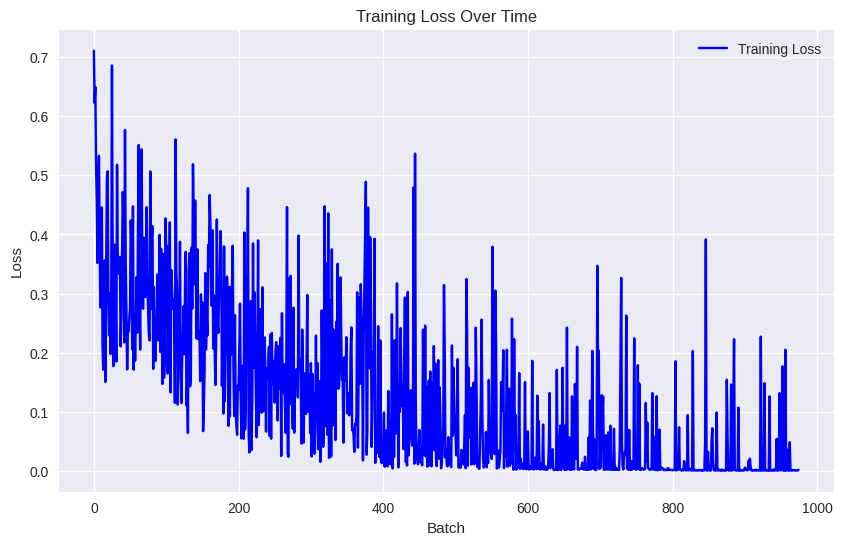

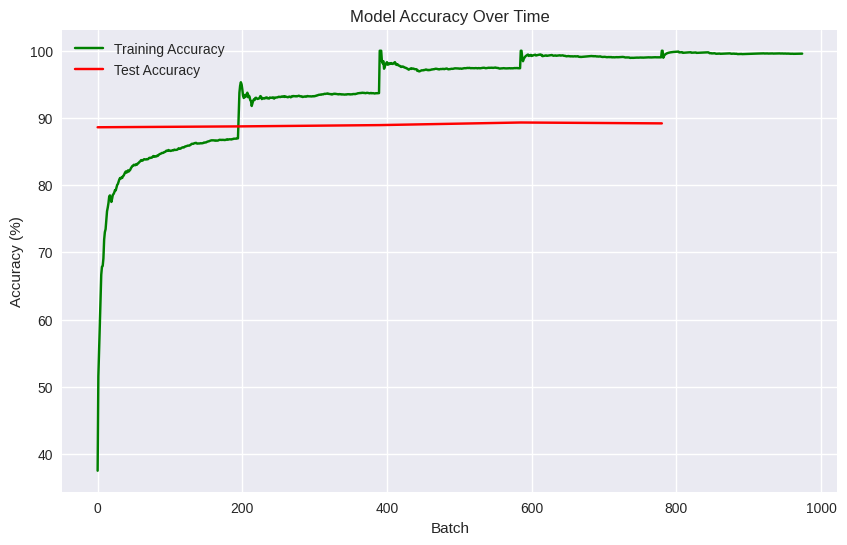

In [10]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = SentimentClassifier()
    
    # 训练模型并获取训练历史
    trained_model, history = train_model(model, train_loader, test_loader, device)
    
    # 保存模型
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'training_history': history
    }, 'sentiment_model_with_history.pth')

In [13]:
import torch
from transformers import BertTokenizer

def predict_sentiment(text, model, device):
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    model.eval()
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.data, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
    sentiment = "正面" if predicted.item() == 1 else "负面"
    probability = probabilities[0][predicted.item()].item()
    
    return {
        'sentiment': sentiment,
        'probability': probability,
        'raw_outputs': outputs[0].tolist()
    }

In [17]:
if __name__ == "__main__":
    # 加载保存的模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SentimentClassifier()
    
    # 加载模型权重并处理"module."前缀
    checkpoint = torch.load('sentiment_model_with_history.pth')
    state_dict = checkpoint['model_state_dict']
    
    # 创建新的state_dict，删除"module."前缀
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k.replace("module.", "") if k.startswith("module.") else k
        new_state_dict[name] = v
    
    # 加载处理后的权重
    model.load_state_dict(new_state_dict)
    model = model.to(device)
    
    # 测试一些样例
    test_texts = [
        "真的要被这家酒店的服务弄的很无语，电视也是坏的，毛巾也是没有洗的 ",
        "酒店房价的环境真的是一言难尽，太他妈的傻逼了这个酒店，床是没有收拾过的，地板也是没有打扫过的，奉劝大家避雷",
        "性价比很高，下次还会选择这家酒店"
    ]
    
    for text in test_texts:
        result = predict_sentiment(text, model, device)
        print(f"\n文本: {text}")
        print(f"情感: {result['sentiment']}")
        print(f"置信度: {result['probability']:.2%}")

<ipython-input-17-cf55d7dd23be>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('sentiment_model_with_history.pth')



文本: 真的要被这家酒店的服务弄的很无语，电视也是坏的，毛巾也是没有洗的 
情感: 负面
置信度: 99.92%

文本: 酒店房价的环境真的是一言难尽，太他妈的傻逼了这个酒店，床是没有收拾过的，地板也是没有打扫过的，奉劝大家避雷
情感: 负面
置信度: 99.91%

文本: 性价比很高，下次还会选择这家酒店
情感: 正面
置信度: 99.94%
